In [156]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression
from aux_funcs import colored_line
# from aux_funcs import parse_string_with_regex, ordered_colors_from_cmap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2.0

In [204]:
def load_hidden_activity(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        print(file_name)
        data_for_file = np.load(file_name)
        print(data_for_file.shape)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

def load_state_data(data_path, indices=[], all=False):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if all or fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

def parse_session(data_path, env_idx, update_num=None):
    indices = [] if update_num is None else [update_num]
    state_data = load_state_data(
        data_path,
        all=True,
    )

    features = [
        'current_patch_num',
        'reward_site_idx',
        'current_reward_site_attempted',
        'agent_in_patch',
        'patch_reward_param',
        'action',
        'reward',
    ]

    all_time_series_dicts = []

    for d in state_data:
        features_to_time_series_dict = {}
        for f in features:
            features_to_time_series_dict[f] = np.zeros((len(d)))
        
        for k in np.arange(len(d)):
            for f in features:
                features_to_time_series_dict[f][k] = d[k][f][env_idx]
    
        dwell_time = np.zeros((len(d)))
        
        for idx in np.arange(0, len(d)):
            if idx > 0 and features_to_time_series_dict['action'][idx] == 0:
                dwell_time[idx] = dwell_time[idx-1] + 1
            else:
                dwell_time[idx] = 0
    
        features_to_time_series_dict['dwell_time'] = dwell_time
        all_time_series_dicts.append(features_to_time_series_dict)
        
    return all_time_series_dicts

def find_patch_trajectories(agent_in_patch_ts):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(agent_in_patch_ts)):
        if agent_in_patch_ts[k] > 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and agent_in_patch_ts[k-1] > 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_odor_site_trajectories(odor_site_indices):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(odor_site_indices)):
        if odor_site_indices[k] == 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and odor_site_indices[k-1] == 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

def find_trajectories_by_patch_type(session_data):
    patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

def find_odor_site_trajectories_by_patch_type(session_data):
    patch_starts_and_ends = find_odor_site_trajectories(session_data['reward_site_idx'])
    trajs_by_patch_type = [[], [], []]
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_num = int(session_data['current_patch_num'][patch_traj_indices][0])
        trajs_by_patch_type[patch_num].append(patch_traj_indices)
    return trajs_by_patch_type

In [197]:
data = load_hidden_activity('../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_08_12_00_029188/hidden_activity/*.npy')
print(data.shape)
all_session_data = [parse_session('../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_08_12_00_029188/state', env_idx) for env_idx in range(20)]
all_session_data = [sd for l in all_session_data for sd in l]

../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_08_02_37_366356/hidden_activity\00000.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_08_02_37_366356/hidden_activity\00001.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_08_02_37_366356/hidden_activity\00002.npy
(5000, 20, 128)
../data/rl_agent_outputs/test_run_all_same_seed_2024-10-02_08_02_37_366356/hidden_activity\00003.npy
(5000, 20, 128)
(5000, 80, 128)
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
4
['00000.pkl', '00001.

[-0.23401390684344747, -0.16015022962754544, -0.09678777041460784, -0.054109586721134306, -0.08340541756130482, -0.13836218631352515, -0.09354847526157428, -0.12443512684229252, -0.1259706212538092, -0.14715559472690098]


(0.0, 1.1)

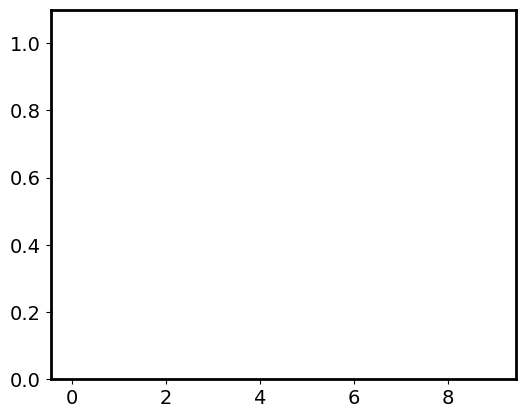

In [203]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(5 * scale, 4 * scale))

pred_accuracies = []
    
for i in range(0, 10):
    train_hidden = []
    test_hidden = []
    train_reward_params = []
    test_reward_params = []

    for env_idx in range(0, 80):
        session_data = all_session_data[env_idx]
        trajs_by_patch_type = find_odor_site_trajectories_by_patch_type(session_data)
        for k in range(3):
            test_hidden.append(data[trajs_by_patch_type[k][-1], env_idx, :])
            test_reward_params.append(session_data['patch_reward_param'][trajs_by_patch_type[k][-1]]) 
            for i_prime in range(i, i+1):
                train_hidden.append(data[trajs_by_patch_type[k][i_prime], env_idx, :])
                train_reward_params.append(session_data['patch_reward_param'][trajs_by_patch_type[k][i_prime]])

    train_hidden = np.concatenate(train_hidden, axis=0)
    test_hidden = np.concatenate(test_hidden, axis=0)
    train_reward_params = np.concatenate(train_reward_params, axis=0)
    test_reward_params = np.concatenate(test_reward_params, axis=0)
    
    reg = LinearRegression().fit(train_hidden, train_reward_params)
    pred_accuracies.append(reg.score(test_hidden, test_reward_params))

axs.plot(np.arange(len(pred_accuracies)), pred_accuracies, c='black', alpha=1)
print(pred_accuracies)
axs.set_ylim(0, 1.1)

In [118]:
def masks_to_colors(masks):
    c = np.zeros(masks[0].shape)
    for mask_idx, mask in enumerate(masks):
        c[mask] = mask_idx + 1
    return c